# Intro

The goal of this project is to develop a **fake news filtering software**.
To make such **filters**, I **utilized known features** of fake news as well as **newly identified features** of fake news from the **explorative data analysis with natural language processings**.
Then I'll apply those filters on the **naive bayes** machine learning model, which often shows good performance on keyword based document classification. Not only using **the built-in scikit-learn naive bayse model**, which can use **only words in the text**, I'll include **additional probability terms** based on other **non-word features** in order to calculate **the final probability of fake news classification**.

# Data

The dataset is provide by Information Security and Object Technology (ISOT) research lab, University of Victoria.
https://www.uvic.ca/engineering/ece/isot/datasets/fake-news/index.php

The dataset contains 21k of real news scrapped from "Reuters.com" and 24k of fake news collected from different sources, where all of them are flagged as unreliable by Polififact (a fact-checking organization in the USA) and Wikipedia. The coverage of topics are various, yet mostly about politics.

Provided dataset are **True.csv** (reuter news) and **Fake.csv** (unreliable news), both have **title, text, subject, and publication date**.

# Known characteristics of fake news

I summarized the judging criteria about credibility of news into three categories.

1. Information-wise

    1. Lack of information
        
        1. Lack of necessary information, like 5W1H
        2. Lack of context, not the whole truth

    2. Not a NEWs
    
        1. Outdated
        
    3. Not valuable
    
        1. Not impactful/important socially
        2. Not a rare event
        3. Nothing to do with the area where news provider cover
        
2. Tone

    1. Doesn't sounds professional
    
        1. Contain slangs
        2. Vocabularies are not specific
    
    2. Hateful
    
        1. Enhance bias or discrimination
        2. Provocative
        
    3. Urgent and Agitative
    
        1. Make readers to spread this news as much as you can
        2. Make reader to act promptly
        
    4. Joke (or pretend to be a joke)
    
        1. Make fun of someone/organization/policy
        
    5. Clickbait

        1. The title contains the above

3. Source-wise

    1. Author
    
        1. Cannot find the name of author
        2. The author is fake
        3. The author is not a reliable person/organization
        
    2. Media/Publishing organization
    
        1. The media is not reliable of fishy

    3. Supporting evidence
    
        1. The evidence that support the news is not adequate
        2. Not provided by a relavant expert or organization

# EDA

The goal of this EDA is to find extractable and useful features which can utilize the known characterastics of fake news, as well as to find unexpected features of fake news. There are tons of items to explore. Fun!

In [34]:
import pandas as pd
import numpy as np
import re

from nltk.help import upenn_tagset

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag, RegexpParser
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB 
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df0 = pd.read_csv('True.csv')
df1 = pd.read_csv('Fake.csv')

In [3]:
# Let's check how many valid entries we have

print(df0.info())
print(df1.info())

print(df0[df0.text.str.len()<10].count())
print(df1[df1.text.str.len()<10].count())
print(df0[df0.title.str.len()<10].count())
print(df1[df1.title.str.len()<10].count())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None
title      1
text       1
subject    1
date       1
dtype: int64
title      651
text       651
subject    651
date       651
dtype: int64
title      0
text       0
subject    0
date       0
dtype: int64
title      1
text       1
subject    1
date

### Observation 1
- Unfortunately, this dataset doesn't contain the name of author. Empty or fake author name could be a strong feature which yield high precition.
- 2.8% of fake news **don't have texts**.

In [4]:
# Let's check a few examples of raw data

pd.options.display.max_colwidth = 200
#print(df0.head(20))
#print(df1.head(20))
#print(df0.iloc[4][1])

### Observation 2
- Real news sounds more informative, whereas fake news sounds **gossip**, although it's hard to tell why I feel that way. What's **relevant feature?**
- Interesting observation about **names** is that in the real news, they are either "title+full name" or "last name", whereas in fake news, they are sometimes **just full names without title**.
- "Subject" column doesn't seem to be useful

Average title length in characters
Real: 64.667880655554 +- 9.168998728700778
Fake: 94.19803245176952 +- 27.184433137131766 

Average text length in characters
Real: 2383.278517065882 +- 1684.8357303747152
Fake: 2547.396235254035 +- 2532.8843992489196 

Average title length in number of words
Real: 9.954475416725032 +- 1.7007465775244577
Fake: 14.732805246795282 +- 4.335099114452772 

Average text length in number of words
Real: 385.6400989867862 +- 274.00620358361635
Fake: 423.1979046888974 +- 408.38889043663846 



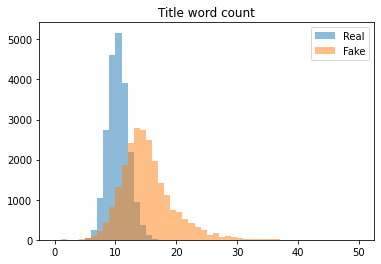

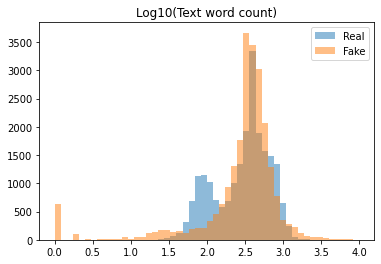

In [5]:
# Let's check 1. A. lack of information - does fake news has smaller size of text?

print("Average title length in characters")
print("Real:", df0.title.str.len().mean(),"+-",df0.title.str.len().std())
print("Fake:", df1.title.str.len().mean(),"+-",df1.title.str.len().std(),"\n")

print("Average text length in characters")
print("Real:", df0.text.str.len().mean(),"+-",df0.text.str.len().std())
print("Fake:", df1.text.str.len().mean(),"+-",df1.text.str.len().std(),"\n")

print("Average title length in number of words")
print("Real:", df0.title.str.split().str.len().mean(),"+-",df0.title.str.split().str.len().std())
print("Fake:", df1.title.str.split().str.len().mean(),"+-",df1.title.str.split().str.len().std(),"\n")

print("Average text length in number of words")
print("Real:", df0.text.str.split().str.len().mean(),"+-",df0.text.str.split().str.len().std())
print("Fake:", df1.text.str.split().str.len().mean(),"+-",df1.text.str.split().str.len().std(),"\n")

#plt.hist(df0.title.str.len(), alpha=0.5, range=(0,250), bins=50)
#plt.hist(df1.title.str.len(), alpha=0.5, range=(0,250), bins=50)
#plt.title("Title length")

#plt.legend(['Real','Fake']) 
#plt.show()

plt.hist(df0.title.str.split().str.len(), alpha=0.5, range=(0,50), bins=50)
plt.hist(df1.title.str.split().str.len(), alpha=0.5, range=(0,50), bins=50)
plt.title("Title word count")

plt.legend(['Real','Fake']) 
plt.show()

#plt.hist(np.log10(df0.text.str.len()), alpha=0.5, range=(0,5), bins=50)
#plt.hist(np.log10(df1.text.str.len()), alpha=0.5, range=(0,5), bins=50)
#plt.title("Log10(Text length)")

#plt.legend(['Real','Fake']) 
#plt.show()

plt.hist(np.log10(df0.text.str.split().str.len()+1), alpha=0.5, range=(0,4), bins=50)
plt.hist(np.log10(df1.text.str.split().str.len()+1), alpha=0.5, range=(0,4), bins=50)
plt.title("Log10(Text word count)")

plt.legend(['Real','Fake']) 
plt.show()

### Observation 3
- I expected that fake news has much fewer text. Indeed, some of fake news have **extreamly short text size**. However, in most of cases, both real and fake news has similar amount of text, although whether they are informative or not is different story. Meanwhile, keep in mind that in this dataset, fake news have collected from website. We don't know what happens if we include social media.
- Real news has shorter title length with smaller standard deviation. That's seemingly because **briefness** is necessary for news title. **Long title length** can be a useful feature of fake news.

In [68]:
# Does fake news have less WH words that describe 5W1H? 

n0 = df0.text.count()
n1 = df1.text.count()

print(df0.text.str.count('who').sum()/n0)
print(df1.text.str.count('who').sum()/n1,"\n")
print(df0.text.str.count('when').sum()/n0)
print(df1.text.str.count('when').sum()/n1,"\n")
print(df0.text.str.count('where').sum()/n0)
print(df1.text.str.count('where').sum()/n1,"\n")
print(df0.text.str.count('what').sum()/n0)
print(df1.text.str.count('what').sum()/n1,"\n")
print(df0.text.str.count('how').sum()/n0)
print(df1.text.str.count('how').sum()/n1,"\n")
print(df0.text.str.count('why').sum()/n0)
print(df1.text.str.count('why').sum()/n1,"\n")

1.455899519073633
1.967037178995784 

0.4312462062847271
0.7682807376176483 

0.3293178316290797
0.40241045952046334 

0.3635429798757996
0.9382905327711767 

0.5857029462576457
1.1370895617733487 

0.04673857216230098
0.24032196243771559 



### Observation 4
- Different from what I expected, fake news have more WH words.

## Text preprocessing

Now we want to explore further with words. To do so, we need to preprocess text first. Let's define useful functions first.

In [88]:
#print(upenn_tagset())

# nltk.pos_tag to lemmatizer input
def convert_pos(word):
    
    word_pos = pos_tag([word])
    
    tag = ''
    try:
        tag = word_pos[0][1][:2]
    except:
        tag = 'n'
    
    if tag == 'JJ':
        tag = 'a'
    elif tag == 'NN':
        tag = 'n'
    elif tag == 'RB':
        tag = 'r'
    elif tag == 'VB':
        tag = 'v'
    else:
        tag = 'n'
        
    return tag

# get lemmatized words
def get_root_words(corpus):
    
    lemmatizer = WordNetLemmatizer()
    
    root_words = []
    
    # Sentence tokenize
    sentences = sent_tokenize(corpus)

    # Stop word removal
    stop_words = set(stopwords.words('english'))

    
    for sentence in sentences:
        
        # remove non words, keep dots for abbreviation        

        if sentence[-1]!='.':
            print(sentence)
        
        else:
            sentence = sentence[:-1]


        sentence = re.sub('[.]','_',sentence)
        sentence = re.sub('\W+',' ',sentence)
        sentence = sentence.lower()
    
        # word tokenize 
        words = word_tokenize(sentence)
        # remove stop words
        words = [word for word in words if word not in stop_words]

        # lemmatize
        lemmatized = [lemmatizer.lemmatize(word, pos=convert_pos(word)) for word in words] 
        
        root_words.append(lemmatized)
        
    return root_words

print(get_root_words(df0.iloc[6][1])) # test

[['west', 'palm', 'beach', 'fla', 'reuters', 'president', 'donald', 'trump', 'say', 'thursday', 'believe', 'fairly', 'treat', 'special', 'counsel', 'investigation', 'russian', 'meddling', 'u_s_', 'presidential', 'election', 'say', 'know', 'long', 'probe', 'would', 'last'], ['federal', 'investigation', 'hung', 'trump', 'white', 'house', 'since', 'take', 'office', 'almost', 'year', 'ago', 'trump', 'ally', 'recent', 'week', 'accuse', 'team', 'justice', 'department', 'special', 'counsel', 'robert', 'mueller', 'bias', 'republican', 'president'], ['interview', 'new', 'york', 'time', 'trump', 'appear', 'shrug', 'concern', 'investigation', 'prompt', 'u_s_', 'intelligence', 'agency', 'conclusion', 'russia', 'try', 'help', 'trump', 'defeat', 'democrat', 'hillary', 'clinton', 'hack', 'release', 'embarrass', 'email', 'disseminate', 'propaganda'], ['collusion'], ['think', 'go', 'fair', 'trump', 'say', 'time', 'described', '30', 'minute', 'impromptu', 'interview', 'golf', 'club', 'west', 'palm', 'be

### 

In [75]:
lemmatizer = WordNetLemmatizer()

lemmatizer.lemmatize('cannot', pos='n')

'cannot'

### Observation 4
- Abbreviation cuts

In [ ]:
# Is there any single keywords that repeats a lot?







# Get a random text
text = df.iloc[6][3]

t = ['this is good', 'that is good', 'good hehe', 'this is bad', 'that is bad', 'bad sucks']
l = [0, 0, 0, 1, 1, 1]


counter = CountVectorizer()
counter.fit(t)


print(counter.vocabulary_)
print(counter.transform(t))


    
    

def chunk_counter(pos_text, abbr='NP', n_chunk=30):

    grammar = ''
    
    if abbr == 'Noun':
        grammar = "Noun: {<NN.*>}"
        
    elif abbr == 'Verb':
        grammar = "Verb: {<VB.*>}"
    
    elif abbr == 'Adj':
        grammar = 'Adj: {<JJ.*>}'
        
    elif abbr == 'Adv':
        grammar = 'Adv: {<RB.*>}'    
        
    #grammar = "NP: {<DT>?<JJ>*<NN.*>}" # noun
    #grammar = "VPa: {<DT>?<JJ>*<NN.*><VB.*><RB.?>?}"
    #grammar = "VPb: {<VB.*><DT>?<JJ>*<NN><RB.?>?}" 
    
    else:
        print('Incorrect gabbr')
        return False

        
    # Chunk phrases
    parser = RegexpParser(grammar)
    
    chunks = []
    
    for sentence in pos_text:
        
        chunk = parser.parse(sentence)
        
        for subtree in chunk.subtrees(filter=lambda t: t.label() == abbr):
            chunks.append(tuple(subtree))
        
    # Count phrases
    counter = Counter()

    for chunk in chunks:
        counter[chunk] += 1

    return counter.most_common(10)

print(chunk_counter(pos_text, abbr='Verb'))

In [ ]:
vectorizer = CountVectorizer()

vectorizer.fit(text)

X = vectorizer.transform(text)
y = label

print(vectorizer.vocabulary_)

In [ ]:
classifier = MultinomialNB()
classifier.fit(X,y)

In [ ]:
x = df_read.iloc[100]

print(x)

classifier.predict_proba(vectorizer.transform([x.content]))


In [ ]:


def train_test(df0, df1, n_train=100, fake_size=0.5):
    
    n_fake = int(n_train*fake_size)
    n_real = n_train-n_fake
    
    
    # Organize data
    
    train0, test0 = train_test_split(df0, test_size=0.5)
    train1, test1 = train_test_split(df1, test_size=0.5)
 
    train = pd.concat([train0.sample(n=n_train), train1.sample(n=n_train)])    
    test = pd.concat([test0.sample(n=n_real), test1.sample(n=n_fake)])
    
    train_text = train.text.tolist()
    train_labels = train.label.tolist()

    test_text = test.text.tolist()
    test_labels = test.label.tolist()
    
    
    # Training
      
    counter = CountVectorizer()

    counter.fit(train_text+test_text)

    train_counts = counter.transform(train_text)
    test_counts = counter.transform(test_text)

    classifier = MultinomialNB()
    classifier.fit(train_counts,train_labels)
    
    
    # Test
    predict = classifier.predict(test_counts)

    # n: real news, p: fake news
    tn, fp, fn, tp = confusion_matrix(test_labels,predict,labels=[0,1]).ravel()
    
    ac = accuracy_score(test_labels,predict)
    pr = precision_score(test_labels,predict)
    re = recall_score(test_labels,predict)
    f1 = f1_score(test_labels,predict)
    
    # when real news become target
    ipr = tn/(tn+fn)
    ire = tn/(tn+fp)
    if1 = 2*ipr*ire/(ipr+ire)
     
    return tn, fp, fn, tp, ac, pr, re, f1, ipr, ire, if1

#        tn, fp, fn, tp, ac, pr, re, f1, ipr, ire, if1 = train_test(df0, df1, n_train, fake_size)
#        result.append([n_train, fake_size, n_real, n_fake, ac, pr, re, f1, ipr, ire, if1])

#print(train_test(df0, df1, 100, 0.5))

After playing with the 'chunk_counter' function for a few sentences, I noticed that real news have more specific (you can guess topic based on keywords) and objective terms whereas fake news have more subjective and plain (no idea what's topic based on frequent keywords) terms.